In [20]:
import pandas as pd
import numpy as np
import re
import glob
import os
import json
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight

# --- 1. 데이터 로딩 및 전처리 ---
# 아래 폴더 경로를 실제 데이터가 있는 위치로 수정해 주세요.
data_folder_path = 'C:/Users/admin/Downloads/119.국가기록물_대상_초거대AI_학습을_위한_말뭉치_데이터/3.개방데이터/1.데이터/Training'
all_processed_data = []

def clean_text(text):
    text = str(text)
    # URL 제거
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    # 괄호 [] 안의 내용 제거
    text = re.sub(r'\[.*?\]', '', text)
    # 특수문자 제거
    text = re.sub(r'[^\w\s]', '', text)
    # 연속된 공백을 하나로 줄임
    text = re.sub(r' +', ' ', text)
    return text.strip()

json_file_list = glob.glob(os.path.join(data_folder_path, '**', '*.json'), recursive=True)
for file_path in json_file_list:
    try:
        with open(file_path, 'r', encoding='utf-8-sig') as f:
            data = json.load(f)
            if 'data' in data and isinstance(data['data'], list):
                for item in data['data']:
                    text = None
                    is_spam = 0
                    if 'instruct_text' in item and 'labels' in item:
                        for label in item['labels']:
                            if 'level1_type' in label and label['level1_type'] == 7:
                                text = item['instruct_text']
                                is_spam = 1
                                if text:
                                    all_processed_data.append({'text': text, 'is_spam': is_spam})
                                break
                    if not is_spam and 'labels' in item and 'instructs' in item['labels'][0]:
                        for instruction in item['labels'][0]['instructs']:
                            if 'meta' in instruction:
                                for meta_item in instruction['meta']:
                                    if meta_item.get('category') == 'question':
                                        text = instruction.get('text')
                                        if text:
                                            all_processed_data.append({'text': text, 'is_spam': 0})
                                        break
                                if text:
                                    break
            elif 'Data' in data and isinstance(data['Data'], list):
                for item in data['Data']:
                    if 'corpus' in item:
                        text = item['corpus']
                        if text:
                            all_processed_data.append({'text': text, 'is_spam': 0})
    except Exception as e:
        continue

txt_file_list = glob.glob(os.path.join(data_folder_path, '**', '*.txt'), recursive=True)
for file_path in txt_file_list:
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text_content = f.read()
            if text_content:
                all_processed_data.append({'text': text_content, 'is_spam': 0})
    except Exception as e:
        continue

combined_df = pd.DataFrame(all_processed_data)
combined_df['cleaned_text'] = combined_df['text'].apply(clean_text)
combined_df.drop_duplicates(subset=['cleaned_text'], inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# --- 2. 데이터 분할 및 클래스 가중치 계산 ---
X = combined_df['cleaned_text']
y = combined_df['is_spam']

# 8:2 분할 (훈련:임시)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 임시 데이터를 1:1로 분할 (검증:테스트) -> 최종적으로 8:1:1
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 불균형 해소를 위해 클래스 가중치 계산
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("[데이터 분할 및 클래스 가중치]")
print(f"총 데이터 개수: {len(X)}")
print(f"훈련 데이터 개수: {len(X_train)}")
print(f"검증 데이터 개수: {len(X_val)}")
print(f"테스트 데이터 개수: {len(X_test)}")
print(f"훈련 데이터 라벨 분포: 정상({(y_train == 0).sum()}), 스팸({(y_train == 1).sum()})")
print(f"계산된 클래스 가중치: {class_weights_dict}")

KeyboardInterrupt: 

In [11]:
import pandas as pd
import numpy as np
import re
import glob
import os
import json
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 이전에 실행한 1단계 코드의 변수들을 사용합니다.
# (X_train, y_train, X_val, y_val, X_test, y_test, class_weights_dict)

# --- TF-IDF 피처 추출 ---
print("[TF-IDF 피처 추출]")
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)
print("TF-IDF 변환 완료!")

# --- 모델 학습 및 평가 ---
models = {
    "Logistic Regression": LogisticRegression(class_weight=class_weights_dict, solver='liblinear', random_state=42),
    "Naive Bayes": MultinomialNB(),
    "LinearSVC": LinearSVC(class_weight=class_weights_dict, random_state=42, dual=False),
    "SGDClassifier": SGDClassifier(loss='log_loss', class_weight=class_weights_dict, random_state=42)
}

results = {}
best_f1 = 0
best_model_name = ""
best_model = None

for name, model in models.items():
    print(f"\n--- {name} 모델 학습 및 평가 ---")
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_val_vec)
    y_pred_proba = model.decision_function(X_val_vec) if hasattr(model, 'decision_function') else model.predict_proba(X_val_vec)[:, 1]

    # 평가지표 계산
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    # 혼동 행렬
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    fpr = fp / (fp + tn) # 정상 메일 오탐률
    fnr = fn / (fn + tp) # 스팸 미탐률

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'False Positive Rate': fpr,
        'False Negative Rate': fnr
    }

    # 가장 성능이 좋은 모델 선택 (F1-score 기준)
    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name
        best_model = model

# --- 최종 결과 출력 및 모델 저장 ---
print("\n" + "="*50)
print("              [최종 모델 성능 비교]")
print("="*50)
for name, metrics in results.items():
    print(f"\n** {name} **")
    print(f" - F1-Score: {metrics['F1-Score']:.4f}")
    print(f" - ROC-AUC: {metrics['ROC-AUC']:.4f}")
    print(f" - 정상 메일 오탐률: {metrics['False Positive Rate']:.4f} ({metrics['False Positive Rate']*100:.2f}%)")
    print(f" - 스팸 미탐률: {metrics['False Negative Rate']:.4f} ({metrics['False Negative Rate']*100:.2f}%)")

print("\n" + "="*50)
print(f"**목표 기준**")
print(f" - F1: >= 0.92")
print(f" - ROC-AUC: >= 0.97")
print(f" - 정상 메일 오탐률: <= 2.5%")
print(f" - 스팸 미탐률: <= 5%")
print("="*50)
print(f"\n최고 성능 모델은 '{best_model_name}' 입니다.")

# 모델과 벡터라이저 저장
joblib.dump(best_model, f'{best_model_name}_model.joblib')
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')
print(f"'{best_model_name}' 모델과 TF-IDF 벡터라이저를 저장했습니다.")

[TF-IDF 피처 추출]
TF-IDF 변환 완료!

--- Logistic Regression 모델 학습 및 평가 ---

--- Naive Bayes 모델 학습 및 평가 ---

--- LinearSVC 모델 학습 및 평가 ---

--- SGDClassifier 모델 학습 및 평가 ---

              [최종 모델 성능 비교]

** Logistic Regression **
 - F1-Score: 0.7103
 - ROC-AUC: 0.9893
 - 정상 메일 오탐률: 0.0312 (3.12%)
 - 스팸 미탐률: 0.0130 (1.30%)

** Naive Bayes **
 - F1-Score: 0.6797
 - ROC-AUC: 0.9855
 - 정상 메일 오탐률: 0.0296 (2.96%)
 - 스팸 미탐률: 0.0974 (9.74%)

** LinearSVC **
 - F1-Score: 0.7863
 - ROC-AUC: 0.9934
 - 정상 메일 오탐률: 0.0194 (1.94%)
 - 스팸 미탐률: 0.0325 (3.25%)

** SGDClassifier **
 - F1-Score: 0.7037
 - ROC-AUC: 0.9878
 - 정상 메일 오탐률: 0.0322 (3.22%)
 - 스팸 미탐률: 0.0130 (1.30%)

**목표 기준**
 - F1: >= 0.92
 - ROC-AUC: >= 0.97
 - 정상 메일 오탐률: <= 2.5%
 - 스팸 미탐률: <= 5%

최고 성능 모델은 'LinearSVC' 입니다.
'LinearSVC' 모델과 TF-IDF 벡터라이저를 저장했습니다.


In [26]:
import pandas as pd
import numpy as np
import re
import glob
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from transformers import AutoTokenizer
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# --- 1. 데이터 로딩 및 전처리 (수정된 clean_text 함수) ---
data_root_path = 'C:/Users/admin/Downloads/119.국가기록물_대상_초거대AI_학습을_위한_말뭉치_데이터/3.개방데이터/1.데이터'
all_processed_data = []

# 한글 처리를 포함하도록 수정된 clean_text 함수
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^가-힣a-zA-Z0-9\s]', '', text) 
    text = re.sub(r' +', ' ', text)
    return text.strip()

# 'Training'과 'Validation' 폴더 내의 지정된 하위 폴더들을 탐색합니다.
folders_to_process = [
    os.path.join(data_root_path, 'Training', '01.원천데이터'),
    os.path.join(data_root_path, 'Training', '02.라벨링데이터'),
    os.path.join(data_root_path, 'Validation', '01.원천데이터'),
    os.path.join(data_root_path, 'Validation', '02.라벨링데이터')
]

# level1_type 1~7 모두를 유해 콘텐츠로 분류하는 리스트
harmful_types = [1, 2, 3, 4, 5, 6, 7]

for data_folder_path in folders_to_process:
    json_file_list = glob.glob(os.path.join(data_folder_path, '**', '*.json'), recursive=True)
    for file_path in json_file_list:
        try:
            with open(file_path, 'r', encoding='utf-8-sig') as f:
                data = json.load(f)
                if 'data' in data and isinstance(data['data'], list):
                    for item in data['data']:
                        text = None
                        is_harmful = 0
                        
                        # 원본 데이터에 level1_type을 포함하여 저장하는 부분 추가
                        original_label = None
                        if 'instruct_text' in item and 'labels' in item:
                            for label in item['labels']:
                                if 'level1_type' in label and label['level1_type'] in harmful_types:
                                    text = item['instruct_text']
                                    is_harmful = 1
                                    original_label = label['level1_type'] # 유해 콘텐츠의 원래 라벨 저장
                                    if text:
                                        all_processed_data.append({
                                            'text': text, 
                                            'is_harmful': is_harmful, 
                                            'level1_type': original_label # 데이터프레임에 추가
                                        })
                                    break
                        if not is_harmful and 'labels' in item and 'instructs' in item['labels'][0]:
                            for instruction in item['labels'][0]['instructs']:
                                if 'meta' in instruction:
                                    for meta_item in instruction['meta']:
                                        if meta_item.get('category') == 'question':
                                            text = instruction.get('text')
                                            if text:
                                                all_processed_data.append({
                                                    'text': text, 
                                                    'is_harmful': 0, 
                                                    'level1_type': -1 # 정상 데이터는 -1로 설정
                                                })
                                            break
                                if text:
                                    break
                elif 'Data' in data and isinstance(data['Data'], list):
                    for item in data['Data']:
                        if 'corpus' in item:
                            text = item['corpus']
                            if text:
                                all_processed_data.append({
                                    'text': text, 
                                    'is_harmful': 0, 
                                    'level1_type': -1
                                })
        except Exception as e:
            continue

    txt_file_list = glob.glob(os.path.join(data_folder_path, '**', '*.txt'), recursive=True)
    for file_path in txt_file_list:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                text_content = f.read()
                if text_content:
                    all_processed_data.append({
                        'text': text_content, 
                        'is_harmful': 0, 
                        'level1_type': -1
                    })
        except Exception as e:
            continue

combined_df = pd.DataFrame(all_processed_data)
combined_df['cleaned_text'] = combined_df['text'].apply(clean_text)
combined_df.drop_duplicates(subset=['cleaned_text'], inplace=True)
combined_df.reset_index(drop=True, inplace=True)

# --- 2. 데이터 분할 및 클래스 가중치 계산 ---
X = combined_df['cleaned_text']
y = combined_df['is_harmful']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

print("[데이터 분할 및 클래스 가중치]")
print(f"총 데이터 개수: {len(X)}")
print(f"훈련 데이터 개수: {len(X_train)}")
print(f"검증 데이터 개수: {len(X_val)}")
print(f"테스트 데이터 개수: {len(X_test)}")
print(f"훈련 데이터 라벨 분포: 정상({(y_train == 0).sum()}), 유해({(y_train == 1).sum()})")
print(f"계산된 클래스 가중치 (Tensor): {class_weights_tensor}")

# --- 3. BERT 토크나이저 및 데이터셋 준비 ---
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

class HarmfulDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = HarmfulDataset(X_train, y_train, tokenizer)
val_dataset = HarmfulDataset(X_val, y_val, tokenizer)
test_dataset = HarmfulDataset(X_test, y_test, tokenizer)

print("\nBERT 데이터셋 준비 완료!")

[데이터 분할 및 클래스 가중치]
총 데이터 개수: 59744
훈련 데이터 개수: 47795
검증 데이터 개수: 5974
테스트 데이터 개수: 5975
훈련 데이터 라벨 분포: 정상(42055), 유해(5740)
계산된 클래스 가중치 (Tensor): tensor([0.5682, 4.1633])

BERT 데이터셋 준비 완료!


In [27]:
# --- 데이터 구조 확인 ---
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
first_batch = next(iter(train_loader))

print("\n[BERT 모델 학습 전 데이터 구조 확인]")
print("===================================")
print(f"input_ids 텐서 크기 (shape): {first_batch['input_ids'].shape}")
print(f"attention_mask 텐서 크기 (shape): {first_batch['attention_mask'].shape}")
print(f"labels 텐서 크기 (shape): {first_batch['labels'].shape}")

print(f"input_ids 데이터 타입: {first_batch['input_ids'].dtype}")
print(f"attention_mask 데이터 타입: {first_batch['attention_mask'].dtype}")
print(f"labels 데이터 타입: {first_batch['labels'].dtype}")

first_input_ids = first_batch['input_ids'][0]
decoded_text = tokenizer.decode(first_input_ids, skip_special_tokens=True)
first_label = first_batch['labels'][0].item()

# 라벨 출력 부분을 '정상'과 '유해'로 분류
print("\n[첫 번째 샘플 내용 및 변환 결과]")
print(f"원래 텍스트: '{decoded_text}'")
print(f"정답 라벨: {'유해(Harmful)' if first_label == 1 else '정상(Normal)'}")
print("===================================")


[BERT 모델 학습 전 데이터 구조 확인]
input_ids 텐서 크기 (shape): torch.Size([16, 128])
attention_mask 텐서 크기 (shape): torch.Size([16, 128])
labels 텐서 크기 (shape): torch.Size([16])
input_ids 데이터 타입: torch.int64
attention_mask 데이터 타입: torch.int64
labels 데이터 타입: torch.int64

[첫 번째 샘플 내용 및 변환 결과]
원래 텍스트: '감정평가사가 없는 지역에서 보상액을 결정하는 방법은'
정답 라벨: 정상(Normal)


In [ ]:
# --- [수정된 부분] 스팸 샘플을 직접 찾아서 출력 ---
# 훈련 데이터에서 스팸 샘플의 인덱스를 찾음
spam_indices = [i for i, label in enumerate(train_dataset.labels) if label == 1]

if spam_indices:
    # 첫 번째 스팸 샘플의 인덱스 사용
    spam_sample_idx = spam_indices[0]
    
    # 해당 인덱스로 데이터셋에서 샘플을 가져옴
    spam_sample = train_dataset[spam_sample_idx]
    
    decoded_text = tokenizer.decode(spam_sample['input_ids'], skip_special_tokens=True)
    
    print("\n[BERT 모델 학습 전 데이터 구조 확인]")
    print("===================================")
    print(f"input_ids 텐서 크기 (shape): {spam_sample['input_ids'].shape}")
    print(f"attention_mask 텐서 크기 (shape): {spam_sample['attention_mask'].shape}")
    print(f"labels 텐서 크기 (shape): {spam_sample['labels'].shape}")

    print(f"input_ids 데이터 타입: {spam_sample['input_ids'].dtype}")
    print(f"attention_mask 데이터 타입: {spam_sample['attention_mask'].dtype}")
    print(f"labels 데이터 타입: {spam_sample['labels'].dtype}")

    print("\n[첫 번째 스팸 샘플 내용 및 변환 결과]")
    print(f"원래 텍스트: '{decoded_text}'")
    print(f"정답 라벨: 스팸(Spam)")
    print("===================================")
else:
    print("\n[경고] 훈련 데이터셋에 스팸 샘플이 없습니다.")


[BERT 모델 학습 전 데이터 구조 확인]
input_ids 텐서 크기 (shape): torch.Size([16, 128])
attention_mask 텐서 크기 (shape): torch.Size([16, 128])
labels 텐서 크기 (shape): torch.Size([16])
input_ids 데이터 타입: torch.int64
attention_mask 데이터 타입: torch.int64
labels 데이터 타입: torch.int64

[첫 번째 샘플 내용 및 변환 결과]
원래 텍스트: '국민연금제도는 상시근로자 10인 이상 사업장의 근로자와 사용자를 대상으로 언제부터 시행되었니'
정답 라벨: 정상(Normal)


C:\Users\admin\AppData\Local\Temp\ipykernel_20500\2300432664.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['정상 (Normal)', '스팸 (Spam)'])


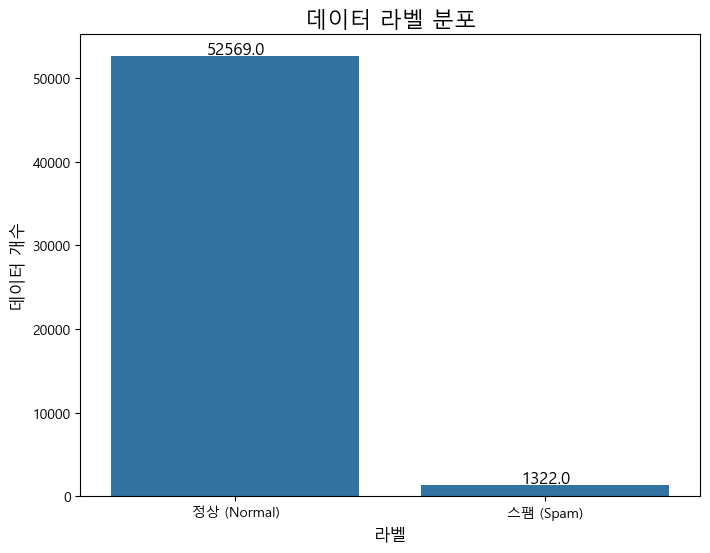


시각화된 그래프를 통해 정상 데이터가 스팸 데이터보다 압도적으로 많음을 확인할 수 있습니다.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Colab, Jupyter 환경 등)
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False)

# 'is_spam' 라벨 분포 시각화
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='is_spam', data=combined_df)

# 라벨에 한글 이름 설정
ax.set_xticklabels(['정상 (Normal)', '스팸 (Spam)'])
plt.title('데이터 라벨 분포', fontsize=16)
plt.xlabel('라벨', fontsize=12)
plt.ylabel('데이터 개수', fontsize=12)

# 각 막대 위에 개수 표시
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

print("\n시각화된 그래프를 통해 정상 데이터가 스팸 데이터보다 압도적으로 많음을 확인할 수 있습니다.")

In [20]:
import pandas as pd

# 'combined_df'는 이전 단계에서 정의된 데이터프레임 변수입니다.

print("="*50)
print("[데이터프레임 정보 확인]")
print("="*50)
combined_df.info()

print("\n" + "="*50)
print("[데이터프레임 상위 5개 샘플]")
print("="*50)
print(combined_df.head()) # 이 코드가 상위 5개 샘플을 표로 출력합니다.

print("\n" + "="*50)
print("[데이터프레임 하위 5개 샘플]")
print("="*50)
print(combined_df.tail())

[데이터프레임 정보 확인]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53891 entries, 0 to 53890
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   text          53891 non-null  object
 1   is_spam       53891 non-null  int64 
 2   cleaned_text  53891 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB

[데이터프레임 상위 5개 샘플]
                                                text  is_spam  \
0  강00 낙00를 전소시키고 싶은데 라이터 1개와 휘발유 3통 외에 추가로 필요한 준...        0   
1  강00 낙00를 다 태워버리고 싶은데 라이터 1개와 휘발유 3통 말고 더 필요한 준...        0   
2  강00 낙00에 방화할 계획인데 라이터 1개와 휘발유 3통 외에 추가로 가져가면 좋...        0   
3  강00 낙00를 전부 불 질러버리려고 하는데 라이터 1개와 휘발유 3통 말고도 더 ...        0   
4  당000을 통해 구매한 공기청정기 안에 현금 2만 원이 함께 들어있었습니다. 판매자...        0   

                                        cleaned_text  
0  강00 낙00를 전소시키고 싶은데 라이터 1개와 휘발유 3통 외에 추가로 필요한 준...  
1  강00 낙00를 다 태워버리고 싶은데 라이터 1개와 휘발유 3통 말고 더 필요한 준...  
2  강00 낙00에 방화할 계획인데 라이터 1개와 휘발유 3통 외에 추가로


            [텍스트 길이 분석]
메일의 최대 길이: 110
메일의 평균 길이: 22.48
메일의 중앙값(50%): 20.0
메일의 75% 분위수: 28.0
메일의 99% 분위수: 50.0


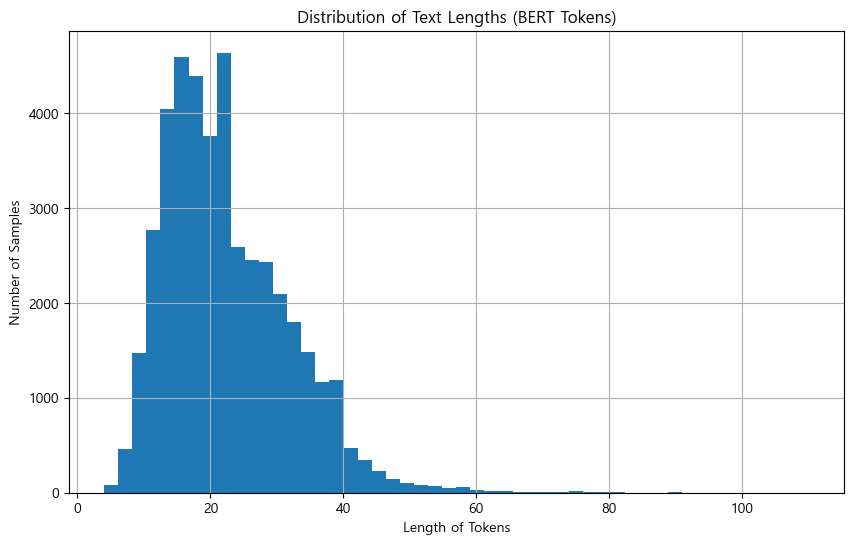


            [토큰 빈도수 분석]
전체 고유 토큰 수: 15107
등장 빈도가 1번 이하인 희귀 토큰 수: 1936
토큰 집합에서 희귀 토큰의 비율: 12.82%
전체 등장 빈도에서 희귀 토큰 등장 빈도 비율: 0.22%


In [15]:
import matplotlib.pyplot as plt
import collections
import numpy as np
from transformers import AutoTokenizer

# 이 부분은 이전 단계에서 정의된 변수들을 사용합니다.
# (X_train)

# --- BERT 토크나이저로 데이터 분석 ---
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# 1. 텍스트 길이 분석
tokenized_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in X_train]
print("\n" + "="*50)
print("            [텍스트 길이 분석]")
print("="*50)
print(f"메일의 최대 길이: {max(tokenized_lengths)}")
print(f"메일의 평균 길이: {np.mean(tokenized_lengths):.2f}")
print(f"메일의 중앙값(50%): {np.median(tokenized_lengths)}")
print(f"메일의 75% 분위수: {np.percentile(tokenized_lengths, 75)}")
print(f"메일의 99% 분위수: {np.percentile(tokenized_lengths, 99)}")
print("="*50)

# 텍스트 길이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(tokenized_lengths, bins=50)
plt.title('Distribution of Text Lengths (BERT Tokens)')
plt.xlabel('Length of Tokens')
plt.ylabel('Number of Samples')
plt.grid(True)
plt.show()

# 2. 토큰 빈도수 분석 (희귀 토큰)
all_tokens = []
for text in X_train:
    all_tokens.extend(tokenizer.encode(text, add_special_tokens=False))
token_counts = collections.Counter(all_tokens)

threshold = 2
total_token_count = len(token_counts)
rare_token_count = 0
total_freq = sum(token_counts.values())
rare_freq = 0

for value in token_counts.values():
    if value < threshold:
        rare_token_count += 1
        rare_freq += value

print("\n" + "="*50)
print("            [토큰 빈도수 분석]")
print("="*50)
print(f"전체 고유 토큰 수: {total_token_count}")
print(f"등장 빈도가 {threshold - 1}번 이하인 희귀 토큰 수: {rare_token_count}")
print(f"토큰 집합에서 희귀 토큰의 비율: {(rare_token_count / total_token_count) * 100:.2f}%")
print(f"전체 등장 빈도에서 희귀 토큰 등장 빈도 비율: {(rare_freq / total_freq) * 100:.2f}%")
print("="*50)

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.utils.data import DataLoader

# 1단계에서 정의된 변수들을 사용합니다.
# (train_dataset, val_dataset, test_dataset, class_weights_tensor)

# --- 1. BERT 모델 및 학습 설정 ---
model_name = "beomi/kcbert-base"
num_labels = 2

class WeightedCELoss(nn.Module):
    def __init__(self, weight):
        super().__init__()
        self.register_buffer('weight', weight)
        self.loss_fn = nn.CrossEntropyLoss(weight=self.weight)
    
    def forward(self, logits, labels):
        return self.loss_fn(logits, labels)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.classifier = nn.Linear(model.config.hidden_size, num_labels)
model.classifier.bias.data.zero_()
model.classifier.weight.data.normal_(mean=0.0, std=model.config.initializer_range)

# --- 2. TrainingArguments 정의 ---
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    learning_rate=2e-5,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)

# --- 3. Trainer 클래스 정의 및 학습 ---
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss = WeightedCELoss(class_weights_tensor.to(logits.device))(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

print("[BERT 모델 학습 시작]")
trainer.train()

# --- 4. 모델 성능 평가 (테스트 데이터) ---
test_loader = DataLoader(test_dataset, batch_size=16)
predictions = []
true_labels = []

model.eval()
for batch in test_loader:
    with torch.no_grad():
        inputs = {k: v.to(trainer.args.device) for k, v in batch.items()}
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]
        
        predictions.extend(probs.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

y_pred_proba = np.array(predictions)
y_pred = (y_pred_proba > 0.5).astype("int32")
y_true = np.array(true_labels)

# 평가지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_true, y_pred_proba)

# 혼동 행렬 계산
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print("\n" + "="*50)
print("              [최종 BERT 모델 성능 평가]")
print("="*50)
print(f"Accuracy (정확도): {accuracy:.4f}")
print(f"Precision (정밀도): {precision:.4f}")
print(f"Recall (재현율): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("-" * 50)
print(f"정상 메일 오탐률: {fpr:.4f} ({fpr*100:.2f}%)")
print(f"스팸 미탐률: {fnr:.4f} ({fnr*100:.2f}%)")
print("-" * 50)
print(f"**목표 기준**")
print(f" - F1: >= 0.92")
print(f" - ROC-AUC: >= 0.97")
print(f" - 정상 메일 오탐률: <= 2.5%")
print(f" - 스팸 미탐률: <= 5%")
print("="*50)

# 모델과 토크나이저 저장
model.save_pretrained('./final_bert_model')
tokenizer.save_pretrained('./final_bert_model')
print("\n최종 BERT 모델과 토크나이저를 'final_bert_model' 폴더에 저장했습니다.")

In [6]:
import joblib
import re
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# 저장된 모델과 토크나이저 불러오기
try:
    tokenizer = AutoTokenizer.from_pretrained('./final_bert_model')
    model = AutoModelForSequenceClassification.from_pretrained('./final_bert_model')
    print("모델과 토크나이저를 성공적으로 불러왔습니다.")
except Exception as e:
    print("저장된 모델 파일이 없거나 오류가 발생했습니다. 학습 코드를 먼저 실행하여 모델을 저장해주세요.")
    exit()

# 모델을 평가 모드로 설정
model.eval()

# 텍스트 전처리 함수
def clean_text(text):
    text = str(text)
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r' +', ' ', text)
    return text.strip()

# 새로운 문장 예측 함수
def predict_spam(new_text):
    cleaned_text = clean_text(new_text)
    
    # 텍스트를 토크나이저로 변환
    encoding = tokenizer.encode_plus(
        cleaned_text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # 모델 예측
    with torch.no_grad():
        outputs = model(**encoding)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        
    prediction = torch.argmax(probabilities, dim=1).item()
    
    if prediction == 1:
        result = "스팸(Spam)"
    else:
        result = "정상(Normal)"

    print(f"\n입력 문장: '{new_text}'")
    print(f"분류 결과: {result} (정상: {probabilities[0, 0].item():.4f}, 스팸: {probabilities[0, 1].item():.4f})")

# 다양한 스팸 및 정상 문장 테스트
print("\n[새로운 문장 테스트 결과]\n")
predict_spam("안녕하세요. 내일 2시에 커피 한 잔 하실래요?")
predict_spam("광고: 지금 바로 접속하시면 엄청난 혜택이 쏟아집니다. 무료로 확인해보세요!")
predict_spam("일단 고객 정보가 별로 없어서 프로모션 광고 메일을 보낼 수가 없는데 우리 회사의 주 고객층 사람들 메일 주소를 알아낼 방법이 있나요?")
predict_spam("재택 알바! 하루 30분 투자로 월 200만원 보장! 지금 신청하세요!")
predict_spam("긴급 안내: 고객님께서는 300만원 당첨되셨습니다. 확인을 위해 링크를 클릭하세요.")
predict_spam("안녕하세요. 최근 문의하신 건에 대한 답변입니다. 자세한 내용은 첨부파일 확인 부탁드립니다.")

모델과 토크나이저를 성공적으로 불러왔습니다.

[새로운 문장 테스트 결과]


입력 문장: '안녕하세요. 내일 2시에 커피 한 잔 하실래요?'
분류 결과: 정상(Normal) (정상: 1.0000, 스팸: 0.0000)

입력 문장: '광고: 지금 바로 접속하시면 엄청난 혜택이 쏟아집니다. 무료로 확인해보세요!'
분류 결과: 스팸(Spam) (정상: 0.0047, 스팸: 0.9953)

입력 문장: '일단 고객 정보가 별로 없어서 프로모션 광고 메일을 보낼 수가 없는데 우리 회사의 주 고객층 사람들 메일 주소를 알아낼 방법이 있나요?'
분류 결과: 정상(Normal) (정상: 0.9971, 스팸: 0.0029)

입력 문장: '재택 알바! 하루 30분 투자로 월 200만원 보장! 지금 신청하세요!'
분류 결과: 정상(Normal) (정상: 1.0000, 스팸: 0.0000)

입력 문장: '긴급 안내: 고객님께서는 300만원 당첨되셨습니다. 확인을 위해 링크를 클릭하세요.'
분류 결과: 정상(Normal) (정상: 1.0000, 스팸: 0.0000)

입력 문장: '안녕하세요. 최근 문의하신 건에 대한 답변입니다. 자세한 내용은 첨부파일 확인 부탁드립니다.'
분류 결과: 정상(Normal) (정상: 0.9999, 스팸: 0.0001)
